In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import localtime, strftime
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import torch.optim as optim
import sklearn.preprocessing as preprocess
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import covariance as cov
import pandas as pd
from pdb import set_trace as bp
%matplotlib inline

In [2]:
from skorch import NeuralNetClassifier
# from skorch.classifier import NeuralNetBinaryClassifier, CVSplit
from skorch.callbacks import EpochScoring

In [3]:
data_dir = '/media/l7/data_storage1/datasets/afib_dataset/training2017/'

## Main Points: 
* Feature Engineering
* Deep Learning (CNN)
* Class imbalance
* PyTorch
* Scorch
* SKLearn


In [4]:

def get_fft(data, absolute_value=True):
    """
    Compute the fft for a specific input dataset.
    :param data:
    :param absolute_value:
    :return:
    """
    fft_data = np.fft.fft(data, axis=1) * 1/data.shape[1]
    if not absolute_value:
        return fft_data
    else:
        abs_fft_data = abs(fft_data[:,:int(fft_data.shape[1] / 2)])
        return abs_fft_data


def label_mapping(label):
    if label == 'N':
        return 0
    elif label =='A':
        return 1
    elif label =='O': 
        return 2
    else: 
        return 3
    
class GeneralDataset(torch_data.Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self,):
        return len(self.data)
    
    def __getitem__(self,index):
        sample = {'signal': torch.tensor(self.data[index]).float(),
                 'label': torch.tensor(self.labels[index]).long()}
        return sample

In [5]:
data_np = np.load(data_dir + 'data_np.npy')
labels_np = np.load(data_dir + 'labels.npy')
data_np

array([[-0.127, -0.162, -0.197, ...,  0.   ,  0.   ,  0.   ],
       [ 0.128,  0.157,  0.189, ...,  0.   ,  0.   ,  0.   ],
       [ 0.056,  0.073,  0.085, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [-0.202, -0.235, -0.272, ...,  0.   ,  0.   ,  0.   ],
       [-0.227, -0.297, -0.374, ...,  0.   ,  0.   ,  0.   ],
       [-0.237, -0.286, -0.338, ...,  0.   ,  0.   ,  0.   ]])

In [6]:
validation_data_np = np.load(data_dir + 'validation_data_np.npy')
validation_labels_np = np.load(data_dir + 'validation_labels.npy')
validation_data_np

array([[-0.127, -0.162, -0.197, ...,  0.   ,  0.   ,  0.   ],
       [ 0.128,  0.157,  0.189, ...,  0.   ,  0.   ,  0.   ],
       [ 0.056,  0.073,  0.085, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.565,  0.676,  0.783, ...,  0.   ,  0.   ,  0.   ],
       [-0.039, -0.06 , -0.077, ...,  0.   ,  0.   ,  0.   ],
       [-0.268, -0.325, -0.383, ...,  0.   ,  0.   ,  0.   ]])

## Establish Sample Size

By definition, we can classify whether or not a signal is Afib with 30 seconds of information. Therefore, in order to make our input dimensions smaller, let's make sure that we have at most 30 seconds worth of information. Based on the sampling frequency, this means that we will have at most 9000 samples in the input dimension. 

In [7]:
sample_size = 9000

## Scale Data for Processing


In [11]:
?preprocess.StandardScaler

In [8]:
standard_scaler = preprocess.StandardScaler()
standard_scaler.fit(data_np[:,:sample_size])
processed_data = standard_scaler.transform(data_np[:,:sample_size])

In [9]:
standard_scaler = preprocess.StandardScaler()
standard_scaler.fit(validation_data_np[:,:sample_size])
validation_processed_data = standard_scaler.transform(validation_data_np[:,:sample_size])

## Add Helper Functions

Below we add a couple of helper functions to aid in the class balancing

In [10]:
def add_noise_to_dataset(data, numpy_data=False, noise_distribution=None, std=1.0):
    """
    This function adds noise to data array. Noise is added for some specific distribution, with a set
    standard deviation.
    :param data: numpy array
    :param numpy_data: bool, describing whether or not the data is a numpy array (otherwise it will be torch tensor)
    :param noise_distribution:
    :param std:
    :return: numpy array with added noise
    """
    numpy_tensor = False
    pytorch_tensor = False
    if not numpy_data:
        if 'numpy' in str(type(data)):
            numpy_tensor = True
            data = torch.tensor(data).float()
        else:
            pytorch_tensor = True

    if not noise_distribution:
        if numpy_data:
            noise_distribution = np.random.randn(data.shape[0], data.shape[1])
            data = data + noise_distribution
        else:
            noise_distribution = np.random.randn(data.shape[0], data.shape[1], data.shape[2])
            data = data + torch.tensor(noise_distribution).float().to(data.device)

    else:
        if numpy_data:
            data = data + noise_distribution(scale=std,
                                             size=[data.shape[0], data.shape[1]])
        else:
            data = data + torch.tensor(
                noise_distribution(scale=std, size=[data.shape[0], data.shape[1], data.shape[2]])).float().to(data.device)
    if pytorch_tensor:
        return data
    elif numpy_data:
        return data
    else:
        return data.numpy()

In [11]:
def double_class_rows(dataset, labels, class_number=1, random_state=1,
                     add_noise=False, noise_distribution=None, std=1.0):
    """
    This function helps balance by adding (or cloning) observations of a specific type.
    :param dataset:
    :param labels:
    :param class_number:
    :param random_state:
    :return:
    """
#     bp()
    sample_rows = np.where(labels == class_number)
    if add_noise:
        dataset_new = add_noise_to_dataset(dataset[sample_rows],
                                numpy_data=True, 
                                noise_distribution=noise_distribution, 
                                std=std)
    else:
        dataset_new = dataset[sample_rows]
    dataset = np.concatenate((dataset, dataset_new))
    labels = np.concatenate((labels, labels[sample_rows]))
    dataset, x_test, labels, y_test = train_test_split(dataset,
                                                      labels,
                                                      test_size=0,
                                                      random_state=random_state)
    print(dataset.shape)
    return dataset, labels
    

In [21]:
classes = ['N', 'A', 'O', '~']
def plot_confusion_matrix(y_pred, y, prefix_information='',
                          dataset_name='', save_results=False,
                          y_pred_is_predicted_classes=False):
    """
    PLotting confusion matrix of different datasets (train, test, and validation).
    :param y_pred:
    :param y:
    :param prefix_information:
    :param dataset_name:
    :param save_results:
    :param y_pred_is_predicted_classes:
    :return:
    """
    if 'Tensor' in str(type(y)):
        y = y.numpy()
    c_matrix = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    result_accuracy_string = "Accuracy of Net: {:.2f}".format(accuracy)
    print(result_accuracy_string)
    print("\nClassification report:")
    classfication_report_string = classification_report(y, y_pred)
    print(classfication_report_string)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    #ax.set_title(dataset_name + " Confusion matrix")
    ax.set_title(" Confusion matrix", fontsize=24)
    sns.heatmap(c_matrix, cmap='Blues', 
                annot=True, xticklabels=classes, 
                yticklabels=classes, fmt='g', cbar=False)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xlabel('predictions', fontsize=22)
    ax.set_ylabel('true labels', fontsize=22)
    plt.tick_params(labelsize=18)
    plt.tight_layout()
    # plt.show()
    return accuracy
    

In [73]:
class LeNet5(nn.Module):
    def __init__(self, n_channels, n_features, mid_layer_channels=10,
                 C_k_p_s_1=[5, 0, 1], M_k_s_1=[2, 2], C_k_p_s_2=[5, 0, 1],
                 M_k_s_2=[2, 2], p=[0.0, 0.0, 0.0, 0.0, 0.0]):
        """
        Replica of a LeNet5 model, with adaptable parameters
        :param n_channels: number of channels in the input data
        :param n_features: number of features in the input data
        :param mid_layer_channels: number of layers which will be produced by the 
        the middle CNN layer
        :param C_k_p_s_1: list containing kernel_size, padding, and stride
        :param C_k_p_s_2: list containing kernel_size, padding, and stride 
        :param M_k_s_1: list containing max pooling kernel_size and stride
        :param M_k_s_2: list containing max pooling kernel_size and stride
        :param p: dropout layer probabilities
        """
        super(LeNet5, self).__init__()
        self.name = 'LetNet5'
        self.conv1d_1 = nn.Conv1d(n_channels, mid_layer_channels,
                                  kernel_size=C_k_p_s_1[0], padding=C_k_p_s_1[1],
                                  stride=C_k_p_s_1[2])
        self.relu = nn.ReLU()
        self.max_pool_1 = nn.MaxPool1d(kernel_size=M_k_s_1[0],
                                       stride=M_k_s_1[1])
        current_input_size = \
        (1 + (n_features - C_k_p_s_1[0] + 2 * C_k_p_s_1[1]) / C_k_p_s_1[2]) / M_k_s_1[0]
        current_input_size = int(current_input_size)
        self.drop_out_1 = nn.Dropout(p=p[0])
#         bp()
        self.conv1d_2 = nn.Conv1d(mid_layer_channels,
                                  2 * mid_layer_channels, 
                                  kernel_size=C_k_p_s_2[0],
                                  padding=C_k_p_s_2[1],
                                  stride=C_k_p_s_2[2])
        current_input_size = \
        (1 + (current_input_size - C_k_p_s_2[0] + 2 * C_k_p_s_2[1]) / C_k_p_s_2[2]) / M_k_s_1[0]
        current_input_size = int(current_input_size)
        self.drop_out_2 = nn.Dropout(p=p[1])
#         bp()
        self.max_pool_2 = nn.MaxPool1d(kernel_size=M_k_s_2[0],
                                       stride=M_k_s_2[1])
#         bp()
        self.fc1 = nn.Linear(2 * mid_layer_channels * current_input_size, 120)
        self.drop_out_3 = nn.Dropout(p=p[2])
        self.fc2 = nn.Linear(120, 84)
        self.drop_out_4 = nn.Dropout(p=p[3])
        self.fc3 = nn.Linear(84, 10)
        self.drop_out_5 = nn.Dropout(p=p[4])
        self.soft_max = nn.Softmax(dim=1)
        self.fc4 = nn.Linear(10, 4)
        
    def forward(self, x):
#         bp()
        x = x.float()
        x = self.max_pool_1(self.relu(self.drop_out_1(self.conv1d_1(x))))
        # bp()
        x = self.max_pool_2(self.relu(self.drop_out_2(self.conv1d_2(x))))
        x = x.view(x.shape[0], x.shape[1] * x.shape[2])
        x = self.relu(self.drop_out_3(self.fc1(x)))
        x = self.relu(self.drop_out_4(self.fc2(x)))
        x = self.relu(self.drop_out_5(self.fc3(x)))
        x = self.fc4(x)
        x = self.soft_max(x)
        return x


In [23]:
def train_model(n_features, n_channels, x_train, y_train,
               device = torch.device('cuda'), model_name = LeNet5.__name__,
               model = None, n_epochs = 10):
    if model is None:
        model = NeuralNetClassifier(module=LeNet5, 
                                    criterion=nn.CrossEntropyLoss,
                                    module__n_channels= n_channels,
                                    module__n_features=n_features,
                                    optimizer=optim.Adam, 
                                    optimizer__lr=0.001,
                                    max_epochs=n_epochs, 
                                    batch_size=32,
                                    iterator_train__shuffle=True,
                                    device=device,
                                    warm_start=True,
                                   )
    model.fit(x_train, y_train, epochs=n_epochs)
    pred_train = model.predict(x_train)
    accuracy = plot_confusion_matrix(pred_train, y_train, )
    return model, pred_train, accuracy
    

In [137]:
train_data = processed_data
test_data = validation_processed_data
labels_train = labels_np


In [138]:
labels_test = validation_labels_np

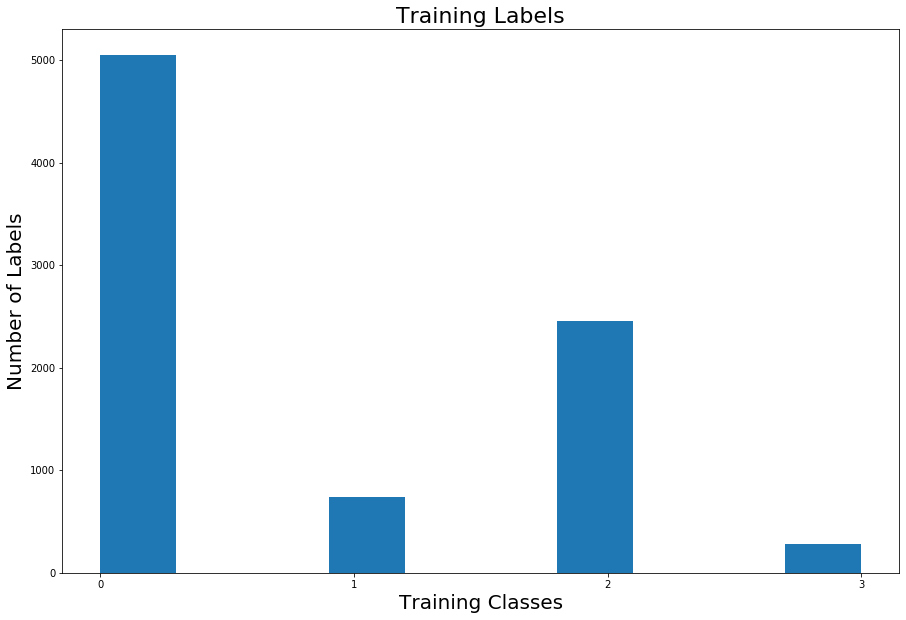

In [139]:
plt.figure(figsize=(15,10))
plt.hist(labels_train)
plt.title('Training Labels', fontsize=22)
plt.xlabel('Training Classes', fontsize=20)
plt.xticks([0, 1, 2, 3])
plt.ylabel('Number of Labels', fontsize=20)
plt.show()

In [140]:
train_data, labels_train = double_class_rows(train_data, labels_np, class_number=1, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.3)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=1, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)

(9266, 9000)
(9550, 9000)
(10118, 9000)
(11594, 9000)


In [ ]:
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=3, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.3)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=2, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)
train_data, labels_train = double_class_rows(train_data, labels_train, class_number=1, 
                                             noise_distribution=np.random.normal, 
                                             add_noise=True, std=0.1)

(12730, 9000)
(15002, 9000)


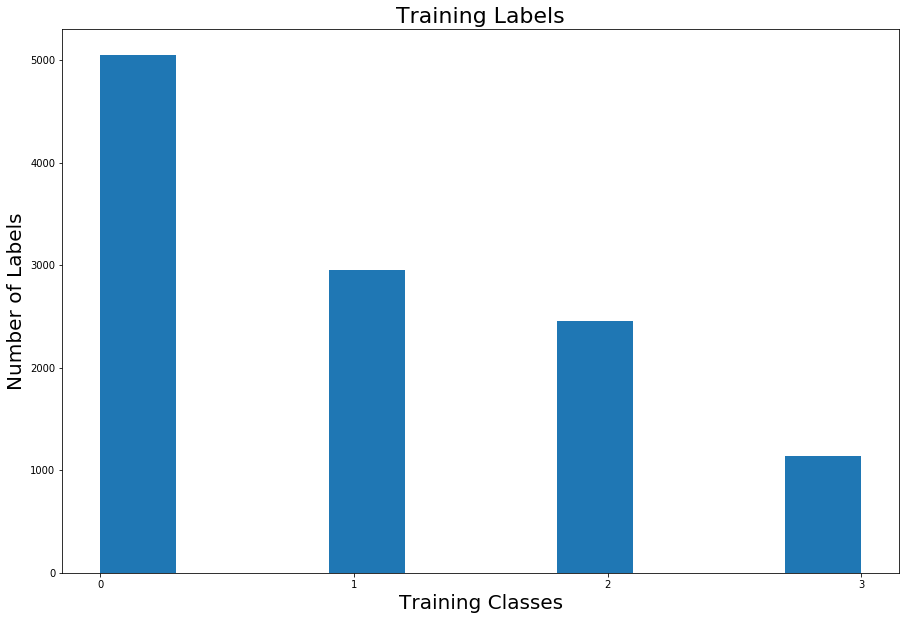

In [122]:
plt.figure(figsize=(15,10))
plt.hist(labels_train)
plt.title('Training Labels', fontsize=22)
plt.xlabel('Training Classes', fontsize=20)
plt.xticks([0, 1, 2, 3])
plt.ylabel('Number of Labels', fontsize=20)
plt.show()

## Get FFT features of the Data

In [123]:
fft_train_data = get_fft(data=train_data, absolute_value=True)

In [124]:
fft_test_data = get_fft(data=test_data, absolute_value=True)
fft_test_data.shape

(300, 4500)

In [125]:
fft_train_data.shape

(11594, 4500)

In [126]:
dimension_size = 3000

In [127]:
x_train = torch.tensor(fft_train_data[:,:dimension_size]).float().unsqueeze(1)
y_train = torch.tensor(labels_train).long()
x_train.shape

torch.Size([11594, 1, 3000])

In [128]:
x_test = torch.tensor(fft_test_data[:,:dimension_size]).float().unsqueeze(1)
y_test = torch.tensor(labels_test).long()
x_test.shape

torch.Size([300, 1, 3000])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3096       0.4352        1.3029  1.3742
      2        1.3066       0.4352        1.3085  1.3257
      3        1.3071       0.4352        1.3085  1.3275
      4        1.3046       0.4352        1.2997  1.3302
      5        1.2666       0.6368        1.1212  1.3370
      6        1.0922       0.6747        1.0634  1.3370
      7        1.0681       0.6575        1.0863  1.3349
      8        1.0661       0.6782        1.0647  1.3389
      9        1.0666       0.6816        1.0569  1.3296
     10        1.0740       0.6859        1.0538  1.3309
     11        1.0595       0.6894        1.0510  1.3369
     12        1.0645       0.6898        1.0501  1.3416
     13        1.0594       0.6807        1.0625  1.3409
     14        1.0566       0.6898        1.0516  1.3410
     15        1.0525       0.6876        1.0493  1.3361
     16        1.0323       0.6

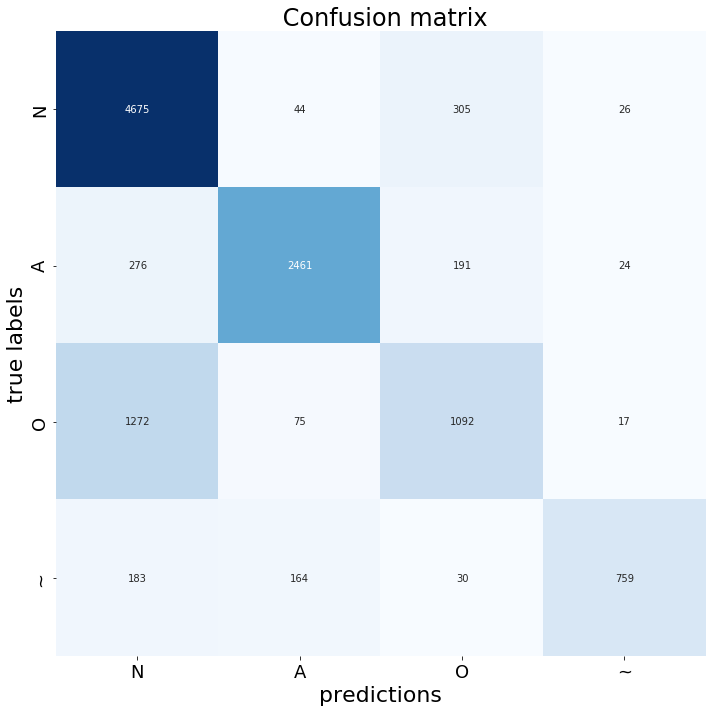

In [135]:
fft_model, \
fft_pred_train, \
fft_accuracy = train_model(n_features=dimension_size, n_channels=1, x_train=x_train,
           y_train=y_train, n_epochs=40)

Accuracy of Net: 0.64

Classification report:
              precision    recall  f1-score   support

           0       0.65      0.91      0.76       150
           1       0.70      0.32      0.44        50
           2       0.50      0.39      0.44        70
           3       0.85      0.37      0.51        30

   micro avg       0.64      0.64      0.64       300
   macro avg       0.67      0.50      0.54       300
weighted avg       0.64      0.64      0.61       300



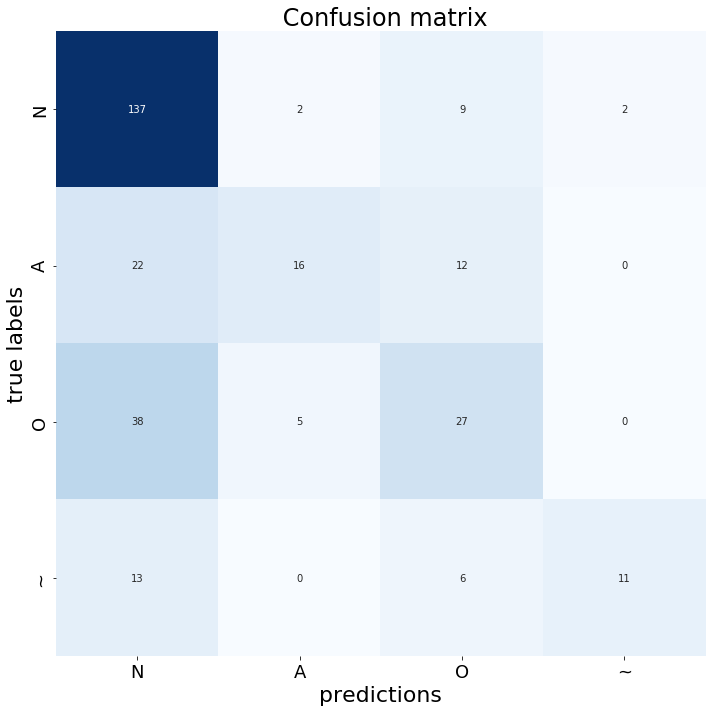

In [136]:
pred_test = fft_model.predict(x_test)
accuracy = plot_confusion_matrix(pred_test, y_test)

## Get PCA Features from the Data

In [ ]:
eigen_values = np.load(data_dir + 'eigen_values_train_data.npy')
eigen_vectors = np.load(data_dir + 'eigen_vectors_train_data.npy')

In [92]:
eigen_values[:dimension_size]

array([2.65990677e+02, 2.33120931e+02, 2.24581366e+02, ...,
       9.16874993e-02, 9.17441601e-02, 9.19017255e-02])

In [93]:
pca_train_data = train_data.dot(eigen_vectors[:,:dimension_size])
pca_train_data.shape

(20410, 3000)

torch.Size([20410, 1, 3000])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0459       0.7757        0.9650  2.4723
      2        0.9884       0.7779        0.9578  2.3475
      3        0.9498       0.7443        0.9945  2.3526
      4        0.9290       0.7788        0.9567  2.3462
      5        0.9096       0.8009        0.9370  2.3570
      6        0.8761       0.8241        0.9175  2.3488
      7        0.8567       0.8229        0.9189  2.3511
      8        0.8439       0.8491        0.8950  2.3524
      9        0.8377       0.8491        0.8938  2.3514
     10        0.8288       0.8496        0.8908  2.3612
     11        0.8174       0.8504        0.8918  2.4856
     12        0.8112       0.8636        0.8782  2.3602
     13        0.8083       0.8633        0.8774  2.3606
     14        0.8058       0.8646        0.8778  2.3550
     15        0.7988       0.8614        0.8805  2.3510
  

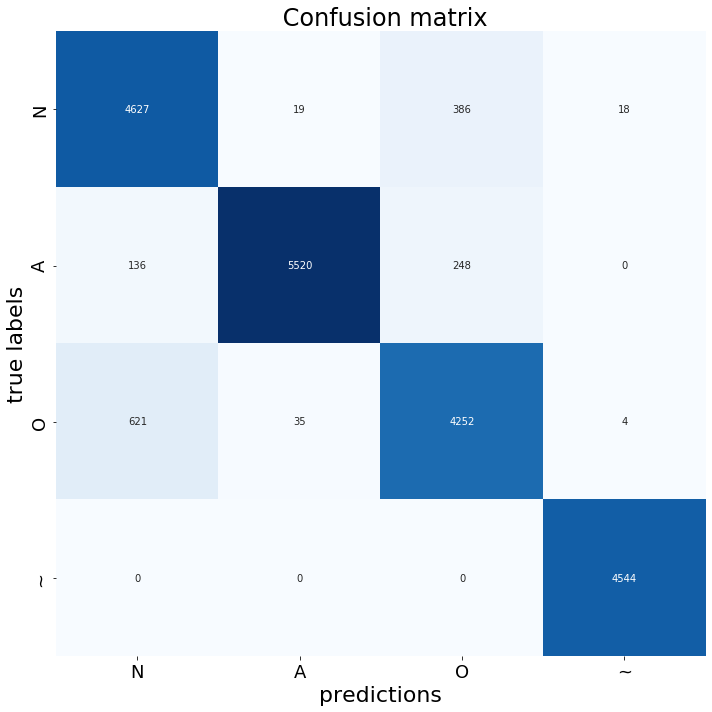

In [94]:
x_train = torch.tensor(pca_train_data).float().unsqueeze(1)
print(x_train.shape)
pca_model, \
pca_pred_train, \
pca_accuracy = train_model(n_features=dimension_size, n_channels=1, x_train=x_train,
           y_train=y_train, n_epochs=20)

## Get Statistical Features

In [95]:
stat_train_data = np.zeros([train_data.shape[0], 5])
stat_train_data[:, 0] += np.max(train_data, axis=1)
stat_train_data[:, 1] += np.min(train_data, axis=1)
stat_train_data[:, 2] += np.mean(train_data, axis=1)
stat_train_data[:, 3] += np.median(train_data, axis=1)
stat_train_data[:, 4] += np.std(train_data, axis=1)
stat_train_data.shape

(20410, 5)

In [96]:
stat_train_data[0]

array([ 3.85051408, -2.08242993, -0.00409358, -0.10331411,  0.67377406])

## Build Input Data with Concated Features

Here, we concatenate the features, in order to produce an input dataset that contains the all features

In [97]:
train_input_dimension = dimension_size\
                        + dimension_size\
                        + stat_train_data.shape[1]
all_feature_train_data = np.zeros([train_data.shape[0], train_input_dimension])

In [98]:
all_feature_train_data[:,:stat_train_data.shape[1]] += stat_train_data
all_feature_train_data[:,stat_train_data.shape[1]:stat_train_data.shape[1]\
                       + dimension_size] += pca_train_data
all_feature_train_data[:,stat_train_data.shape[1]\
                       + dimension_size:stat_train_data.shape[1]\
                       + 2 * dimension_size] += fft_train_data[:,:dimension_size]

torch.Size([20410, 1, 6005])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0470       0.7529        0.9877  4.1203
      2        0.9738       0.7272        1.0073  4.1190
      3        0.9386       0.7977        0.9391  4.0740
      4        0.9147       0.8058        0.9338  4.0866
      5        0.8943       0.8224        0.9162  4.0882
      6        0.8755       0.8256        0.9141  4.0903
      7        0.8529       0.8410        0.8976  4.0899
      8        0.8386       0.8479        0.8936  4.2167
      9        0.8330       0.8530        0.8876  4.5119
     10        0.8138       0.8455        0.8963  4.1824
     11        0.8071       0.8587        0.8853  4.0816
     12        0.8021       0.8406        0.8997  4.0928
     13        0.8070       0.8435        0.8974  4.0946
     14        0.8031       0.8535        0.8868  4.0940
     15        0.7946       0.8594        0.8823  4.0880
  

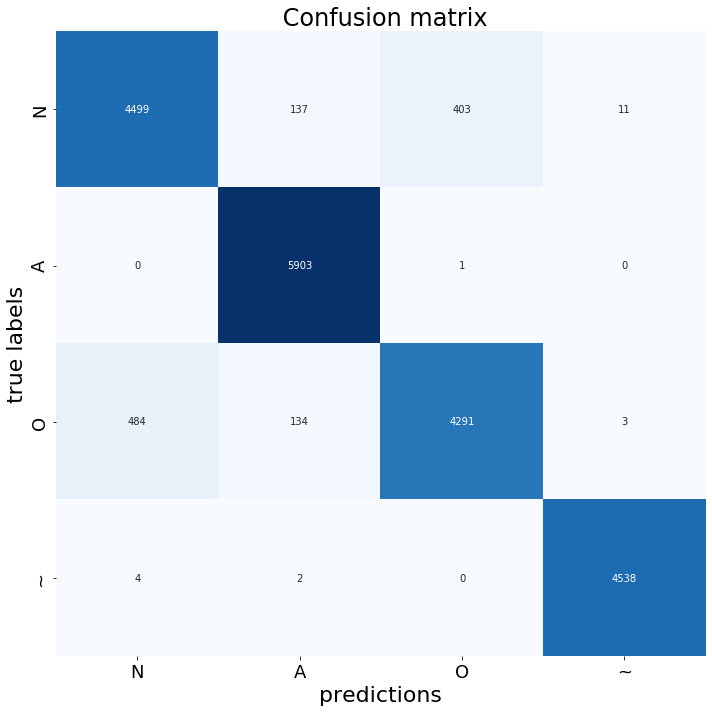

In [99]:
x_train = torch.tensor(all_feature_train_data).float().unsqueeze(1)
print(x_train.shape)
all_feature_model, \
all_feature_pred_train, \
all_feature_accuracy = train_model(n_features=train_input_dimension, 
                                   n_channels=1, x_train=x_train,
           y_train=y_train, n_epochs=20)

## Verifying Feature Correlations

In [100]:
correlations = np.corrcoef(all_feature_train_data, rowvar=False)
correlations

array([[ 1.        , -0.57855954,  0.2653742 , ...,  0.28580382,
         0.26154322,  0.27188927],
       [-0.57855954,  1.        ,  0.24306153, ..., -0.31461095,
        -0.30200439, -0.31059184],
       [ 0.2653742 ,  0.24306153,  1.        , ..., -0.0388657 ,
        -0.05856764, -0.04640667],
       ...,
       [ 0.28580382, -0.31461095, -0.0388657 , ...,  1.        ,
         0.66924121,  0.67781492],
       [ 0.26154322, -0.30200439, -0.05856764, ...,  0.66924121,
         1.        ,  0.66462849],
       [ 0.27188927, -0.31059184, -0.04640667, ...,  0.67781492,
         0.66462849,  1.        ]])

In [101]:
abs_correlations = np.abs(correlations)
mean_corr = abs_correlations.mean(axis=1)
print("mean: {}".format(mean_corr))
min_corr = abs_correlations.min(axis=1)
print("min: {}".format(min_corr))
median_corr = np.median(abs_correlations, axis=1)
print("median: {}".format(median_corr))

mean: [0.15955077 0.17246912 0.02555307 ... 0.24350552 0.2373679  0.23910108]
min: [7.86154883e-07 7.58334660e-07 1.47395847e-07 ... 3.84406938e-07
 9.10248730e-06 1.52929879e-07]
median: [0.15569757 0.19161373 0.00741689 ... 0.06136281 0.05481815 0.05353201]


In [102]:
chosen_features = np.where(mean_corr <=0.005)
number_of_chosen_features = len(chosen_features[0])
print(number_of_chosen_features)


2112


## Training with Least Correlated Features

torch.Size([20410, 1, 2112])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0557       0.7034        1.0210  1.8873
      2        0.9734       0.7712        0.9645  1.8442
      3        0.9483       0.7979        0.9407  1.8567
      4        0.9230       0.7752        0.9655  1.8446
      5        0.9024       0.8077        0.9308  1.8526
      6        0.8870       0.8033        0.9342  1.8455
      7        0.8689       0.8090        0.9316  1.8484
      8        0.8546       0.8325        0.9089  1.8458
      9        0.8410       0.8161        0.9260  1.8424
     10        0.8405       0.8308        0.9106  1.8933
     11        0.8251       0.8406        0.9008  1.8639
     12        0.8197       0.8381        0.9019  1.8507
     13        0.8129       0.8413        0.9004  1.9374
     14        0.8059       0.8459        0.8965  1.8587
     15        0.8054       0.8430        0.8997  1.8605
  

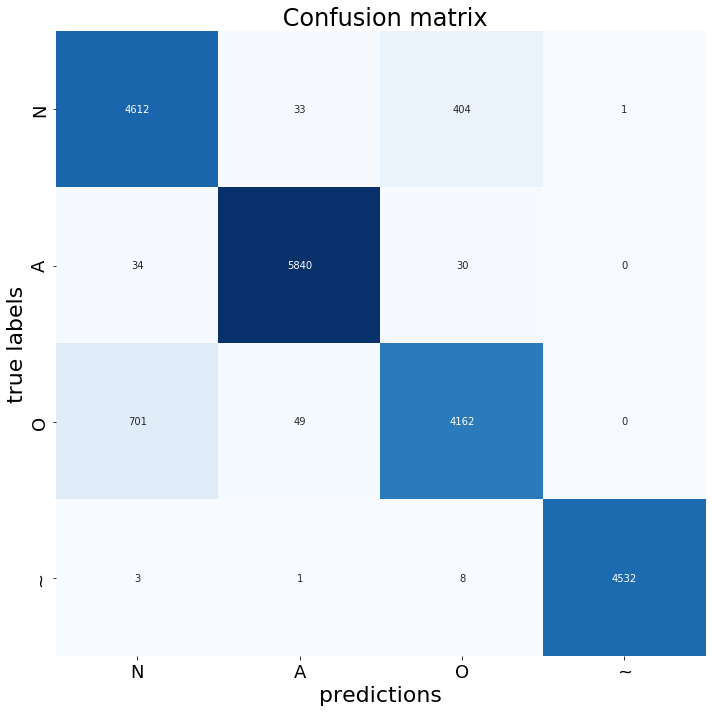

In [103]:
x_train = torch.tensor(all_feature_train_data[:, chosen_features]).float()
print(x_train.shape)
chosen_feature_model, \
chosen_feature_pred_train, \
chosen_feature_accuracy = train_model(n_features=number_of_chosen_features, 
                                   n_channels=1, x_train=x_train,
           y_train=y_train, n_epochs=20)

## Conclusion
* We have seen how to produce different types of features: FFT, PCA, and Stats
* Pytorch, Scorch, and SKLearn used for Deep Learning
* The Value of selecting the less correlated features
* Questions ?! 